In [1]:
import torch
import torch.nn as nn
loaded_module = nn.Linear(4,6)
#loaded_module.load_state_dict()

print(loaded_module.state_dict())
st=torch.load('outputs/fhn1P/initial_conditions/network.0.pth')
print(st)

OrderedDict([('weight', tensor([[-0.1222, -0.1706, -0.1201,  0.2722],
        [-0.3602, -0.4506,  0.0988, -0.3520],
        [-0.2076, -0.0200,  0.2376,  0.3001],
        [ 0.4293, -0.1625, -0.1794,  0.2209],
        [ 0.0751,  0.1235, -0.1029,  0.4033],
        [ 0.4557,  0.4611,  0.2659,  0.4399]])), ('bias', tensor([ 0.2563,  0.2014,  0.1799,  0.2965, -0.2159,  0.0585]))])
OrderedDict([('_impl.layers.0.linear.weight', tensor([[ 0.2217, -0.4893],
        [-0.2422, -0.2661],
        [-0.2954,  0.4892],
        [-0.0252,  0.5018],
        [ 0.0538, -0.5332],
        [ 0.7230, -0.1501],
        [ 0.3324, -0.4464],
        [-0.1240, -0.3384],
        [ 0.0773,  0.1993],
        [ 0.3913,  0.5582],
        [ 0.1043,  0.3439],
        [ 0.2108, -0.2731],
        [ 0.3459,  0.3473],
        [ 0.4553,  0.2609],
        [ 0.2451, -0.4571],
        [-0.1408,  0.3125]], device='cuda:0')), ('_impl.layers.0.linear.weight_g', tensor([[1.0850],
        [1.6957],
        [2.9519],
        [6.6868],
 

In [2]:
import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import collections as coll
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
import gc
import numpy as np
import torch as pt

pt.set_grad_enabled (False) 
numinputs=1
numoutputs=2
class Net(nn.Module):
    def __init__(self, numinputs, numoutputs, numlayers=4, H=10):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.utils.weight_norm(nn.Linear(numinputs, H), name='weight', dim=0).cuda())

        for _ in range(numlayers - 1):
            self.layers.append(nn.utils.weight_norm(nn.Linear(H, H), name='weight', dim=0).cuda())

        self.final_layer = nn.Linear(H, numoutputs).cuda()

        for layer in self.layers:
            layer.eval()
        self.final_layer.eval()

    def forward(self, x):
        for layer in self.layers:
            x = f.silu(layer(x))

        return self.final_layer(x)

    def load(self, od):
        for k, v in od.items():
            if k.startswith('_impl.layers'):
                layer_num = int(k.split('.')[2])
                layer = self.layers[layer_num]
                if k.endswith('linear.weight'):
                    layer.weight_v.data = v
                    layer.weight_v.requires_grad = False
                elif k.endswith('linear.weight_g'):
                    layer.weight_g.data = v
                    layer.weight_g.requires_grad = False
                elif k.endswith('linear.bias'):
                    layer.bias.data = v
                    layer.bias.requires_grad = False
            elif k == '_impl.final_layer.linear.weight':
                self.final_layer.weight.data = v
                self.final_layer.weight.requires_grad = False
            elif k == '_impl.final_layer.linear.bias':
                self.final_layer.bias.data = v
                self.final_layer.bias.requires_grad = False

    def __prepare_scriptable__(self):
        for layer in self.layers:
            for hook in layer._forward_pre_hooks.values():
                if hook.__module__ == "torch.nn.utils.weight_norm" and hook.__class__.__name__ == "WeightNorm":
                    torch.nn.utils.remove_weight_norm(layer)
        return self

import itertools
def ModelrunRT(x=np.linspace(0, 1, num=10),t=np.linspace(0,10,num=10)):
   
    
    X=np.zeros((2,len(t)*len(x)))
    #print(itertools.product(x,t))
    i=0
    for a,b in itertools.product(x,t):
        X[:,i]=(b,a)
        i=i+1
    #print(np.shape(X))
    my2dspace = pt.tensor(X.T, requires_grad=False)
    model.eval()

    myOutput = model(my2dspace.float().cuda())
    myCPUOutput = myOutput.cpu()


    uu = myCPUOutput.numpy()

    #print('uu: ', uu.T[0])

    myCPUOutput.squeeze().detach().numpy()
    return uu



def Modelrun(x=np.linspace(0, 1, num=10),t=np.linspace(0,10,num=10),M=0):
   
    gc.collect()
    torch.cuda.empty_cache()
    X=np.zeros((2,len(t)*len(x)))
    #print(itertools.product(x,t))
    i=0
    for a,b in itertools.product(x,t):
        X[:,i]=(b,a)
        i=i+1
    #print(np.shape(X))
    my2dspace = pt.tensor(X.T, requires_grad=False).float().cuda()
    M.eval()
    start_time = TIME.time()
    myOutput = M(my2dspace)
    reftime = TIME.time()- start_time
 
    myCPUOutput = myOutput.cpu()


    uu = myCPUOutput.numpy()

    #print('uu: ', uu.T[0])

    myCPUOutput.squeeze().detach().numpy()
    gc.collect()
    torch.cuda.empty_cache()
    return uu,reftime




In [3]:
!nvcc cuda.cu -o a.out  ##Estava seguindo o tutorioal do torch rt tentando encontrar uma forma de converter, tentei remover os pesos para então converte 

6
Number of rows in the CSV file:  100000 26
Solving for  100000 cells in  26 timepoints
Shape ref  (2600000,)
ref cuda time [0.000411488, 0.72579718, 0.634148499]
6
Number of rows in the CSV file:  100000 26
Shape cudapred  (2600000,)
cuda time [0.00044864, 0.007811968, 0.596135864]
Error Calculation
mean 0.0003560083142307691
max 0.019296000000000008
(27,)
Shape netpred  (2600000,)
net time 0.034211158752441406
Error Calculation
mean 0.001676447995498471
max 0.06698009157752993


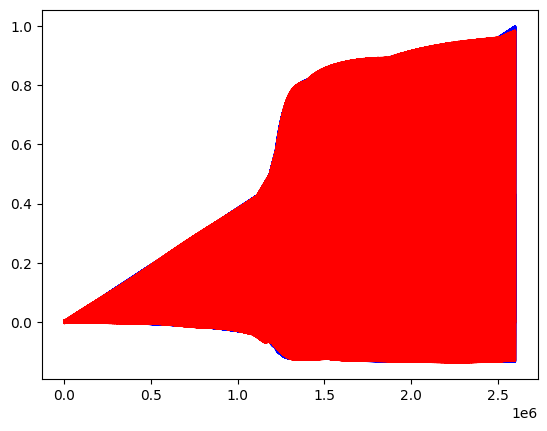

(27,)
Shape netpred  (2600000,)
net time 0.004792213439941406
Error Calculation
mean 0.001676447995498471
max 0.06698009157752993


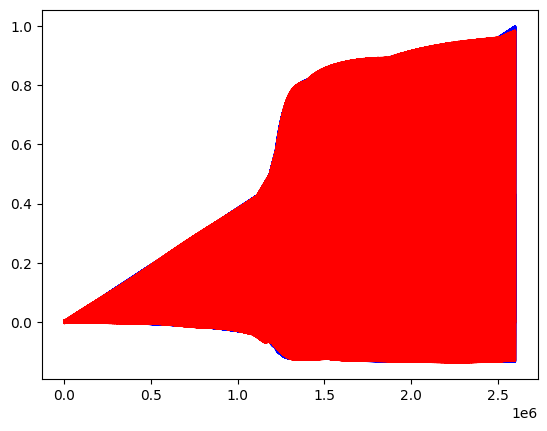

In [3]:

from FHNCUDAlib import FHNCUDA
import numpy as np
import torch 
net =Net(2,2,4,11)
PATH=""
od=pt.load('outputs/fhn1P/initial_conditions/network.0.pth')
net.load(od)
net=net.cuda()


pt.no_grad() 
import time as TIME
x0=np.expand_dims(np.array([(0 + 0.00001*i*1) for i in range(0,100000)]),-1)
dt,tt=0.0001,10

rate=4000

start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt,rate)
reftime = TIME.time()- start_time
p=[i/1000 for i in p[0]]
u_ref=np.array(u).flatten()


print("Solving for ",len(x0),"cells in " ,int(np.shape(u_ref)[0]/len(x0)),"timepoints" )
print("Shape ref ",np.shape(u_ref))
print("ref cuda time",p)



start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt*100,rate/100)
cudatime = TIME.time()- start_time
u_num=np.array(u).flatten()
#print(np.unique(t))
p=[i/1000 for i in p[0]]
print("Shape cudapred ",np.shape(u_num))
print("cuda time",p)
print("Error Calculation")
e=((u_ref-u_num)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)

i=[a for a in range(len(e)) if e[a]==m]
x0 = [item for sublist in x0 for item in sublist]
t = [item for sublist in t for item in sublist]

print(np.shape(t))
start_time = TIME.time()
u,net_time=Modelrun(x0,t[1:],M=net)

u_net=u.T[0].flatten()

print("Shape netpred ",np.shape(u_net))
print("net time", net_time)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref,"b")
plt.plot(u_net,"r")

plt.show()

print(np.shape(t))
start_time = TIME.time()
u,net_time=Modelrun(x0,t[1:],M=torch.jit.script(net).cuda())

u_net=u.T[0].flatten()

print("Shape netpred ",np.shape(u_net))
print("net time", net_time)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref,"b")
plt.plot(u_net,"r")
plt.show()




In [5]:
!nvcc cuda.cu -o a.out